In [1]:
import sys
sys.path.append('../../EquiScore')
import pickle
from train import *
from torch import distributed as dist
import torch.multiprocessing as mp
from dist_utils import *
import utils
import random
from parsing import parse_train_args
args = parse_train_args()
seed_torch(seed = args.seed)
args.ngpu = 1
# args.__dict__

2023-06-16 02:05:06


In [14]:
# select keys to compute 
def getDataLoader(args,key_type= 'active',nums = 10000):
    try:
        with open (args.test_keys, 'rb') as fp:
            keys = pickle.load(fp)
    except:
        keys = args.test_keys
    test_actives = [i for i in keys if '_active'  in i.split('/')[-1] ]
    test_decoys = [i for i in keys if '_active' not in i.split('/')[-1]]
    all_pocket =  test_actives + test_decoys 
    random.shuffle(all_pocket)
    random.shuffle(test_actives)
    random.shuffle(test_decoys)
    
    print(f'actives num : {len(test_actives)} decoys num : {len(test_decoys)}')
    if key_type== 'active':
        test_keys = test_actives[:nums]
    elif key_type== 'decoy' :
        test_keys = test_decoys[:nums]
    else:
        test_keys = all_pocket[:nums]
        
    test_dataset = ESDataset(test_keys,args, args.data_path,args.debug) #测试集看不出什么东西，直接忽略
    # test_dataset = MolDataset(test_keys, args.data_path,args.debug)
    test_sampler = SequentialDistributedSampler(test_dataset,1) if args.ngpu > 1 else None
    test_dataloader = DataLoaderX(test_dataset, 1, sampler=test_sampler,prefetch_factor = 4,\
        shuffle=False, num_workers = 1, collate_fn=test_dataset.collate,pin_memory=True) # 测试集看不出什么东西，直接忽略
    return test_sampler,test_dataloader,test_keys

In [15]:
def getModel(args):
    if args.FP:
        args.N_atom_features = 39
    else:
        args.N_atom_features = 28
    #hyper parameters
    num_epochs = args.epoch
    lr = args.lr
    ngpu = 1
    args.ngpu = 1
    batch_size = args.batch_size = 1
    data_path = args.data_path
    save_dir = args.save_dir
    train_time = time.strftime('%Y-%m-%d-%H-%M-%S')
    #make save dir if it doesn't exist
    #initialize model
    if args.ngpu>0:
        cmd = get_available_gpu(num_gpu=args.ngpu, min_memory=8000, sample=3, nitro_restriction=False, verbose=True)

        if cmd[-1] == ',':
            os.environ['CUDA_VISIBLE_DEVICES']=cmd[:-1]
        else:
            os.environ['CUDA_VISIBLE_DEVICES']=cmd
        print(cmd)
    model = EquiScore(args) if args.model == 'EquiScore' else None
    print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
    # device = torch.device("cuda:{}".format(args.local_rank) if torch.cuda.is_available() else "cpu")
    args.device = 'cuda:0'
    args.local_rank = 'cuda:0'
    model ,opt_dict,epoch_start= utils.initialize_model(model, args.device,args,args.save_model)
    return model


In [47]:
'''
util funcs

'''
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dgl.nn.functional import edge_softmax
def MeanStd(data):
    max_value = max(data)
    min_value = min(data)
    X_std = (data - min_value)/((max_value-min_value) + 1e-11)
    X_scaled  =  X_std*(max_value - min_value) + min_value
    return X_scaled/X_scaled.sum()
def MaxMin(atom_weights):
    min_value = min(atom_weights)
    max_value = max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)
    return atom_weights
def plotAttDist(pred_g):
    score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'])
    atts = score.squeeze(-1).mean(1)
    plt.plot(atts)
def copyAtt(pred_g):
    atts_copy = np.zeros(shape = (len(pred_g.nodes()),len(pred_g.nodes())))
    u,v = pred_g.edges()
    eids = pred_g.edge_ids(u,v)
    atts_copy[u,v]= atts[eids]
    return atts_copy
def getAttnFP(pred_g,fp,n1):
    '''
    get IFP edge attentions and covalent edges attentions
    '''
    # atompairs = fp
    temp_fp= np.array(fp)
    u,v = list(temp_fp[:,0]) +  list((n1+ temp_fp[:,1])),list((n1+ temp_fp[:,1])) + list(temp_fp[:,0])
    eids = pred_g.edge_ids(u,v)
    # all_ids = pred_g.num_
    all_ids = list(range(pred_g.num_edges()))
    eid_res = torch.tensor(list(set(all_ids) - set(eids.data.cpu().numpy()))).to(eids.device)
    
    # score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'].squeeze(-1).mean(1).clamp(-5,5))
    score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'].clamp(-5,5))
#     atts = pred_g.edata['score'].squeeze(-1).mean(1)
    attnFP = score[eids]
    attnCovalent = score[eid_res]
    return attnFP,attnCovalent


In [48]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
import  rdkit.Chem.AllChem as AllChem
IPythonConsole.ipython_useSVG = True
import copy
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from IPython.display import display
import matplotlib
import matplotlib.cm as cm
def InchMap(mol):
    inchi, aux_info = Chem.MolToInchiAndAuxInfo(mol)
    for i in aux_info.split('/'):
        if i[0]=='N':
            pos=i[2:].split(',')
    inchi_to_mol = {i:int(j)-1 for i,j in enumerate(pos)}
    mol_to_inchi = {int(j)-1 :i for i,j in enumerate(pos)}
    return inchi_to_mol,mol_to_inchi
def mol_with_atom_weight( mol ,weights,mol_to_inchi):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp("atomNote", f"{str( round(float(weights[mol_to_inchi[mol.GetAtomWithIdx( idx ).GetIdx()]]),3))}")
    return mol

def drawmol(mol,atom_weights,highlightAtoms =None,flag = ''):
    inchi_to_mol,mol_to_inchi = InchMap(mol)
    weight_inchi = []
    for i in range(len(atom_weights)):
        try:
            weight_inchi.append(atom_weights[inchi_to_mol[i]])
        except:
            weight_inchi.append(atom_weights[i])
                                        
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    weight_inchi = MaxMin(weight_inchi) # 归一化权重
    
    note =flag +  '  vitual node weight:'
    for i in range(len(mol.GetAtoms()),len(weight_inchi)):
        note += f' {i - len(mol.GetAtoms()) + 1} : {round(weight_inchi[i],3)} '
        # print(note)
        

    mol = mol_with_atom_weight( mol ,weight_inchi,mol_to_inchi)
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28) # minmax: (vmin=-1.0, vmax=1.28)： meanstd : (vmin=-0.2, vmax=1.0)
    cmap = cm.get_cmap('bwr')
    
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    # atom_colors = {idx: plt_colors.to_rgba(float(mol.GetAtomWithIdx( idx ).GetProp("atomNote_Score"))) for idx in range(len(mol.GetAtoms()))}
    atom_colors = {idx: plt_colors.to_rgba(float(mol.GetAtomWithIdx( idx ).GetProp("atomNote"))) for idx in range(len(mol.GetAtoms()))}
    
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(1200, 800)
    drawer.SetFontSize(120)
    op = drawer.drawOptions()
     
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(len(mol.GetAtoms())) if not highlightAtoms else highlightAtoms,
                             highlightBonds=[],
                             highlightBondColors=atom_colors,
                             highlightAtomColors=atom_colors,legend = note)

                             
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    return (mol, weight_inchi, svg)

In [49]:

def save_PNG_smilarymap(model,h,mol,pred_g,logit,key,save_dir):
    logit = F.softmax(logit,dim = 1)[:,1].data.cpu().numpy()[0]

    ligand_num = int(pred_g.ndata['V'].sum().data.cpu().numpy())
    # h =  active_gs[idx][0]
    for module in model.weight_and_sum.atom_weighting:
        h = module(h)
    mol, aw, svg = drawmol(mol, h.flatten().data.cpu().numpy()[:ligand_num],flag = ' prob: ' + str(round(logit,4))) 
    
    weights = [float(mol.GetAtomWithIdx( idx ).GetProp("atomNote")) for idx in range(len(mol.GetAtoms()))]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,weights)
    save_path = os.path.join(*[save_dir,os.path.join(*key.split('/')[-2:-1])]) 
    os.makedirs(save_path, exist_ok=True)
    # plt.tight_layout()
    fig.savefig(os.path.join(save_path,key.split('/')[-1] + '_{}.png'.format(round(logit,4))),dpi=660,format='png',bbox_inches='tight')


In [50]:
import dataset_utils
import pickle 
from equiscore_utils import *
from tqdm import tqdm
from cairosvg import svg2png
def save_PNG(model,h,mol,pred_g,logit,key,save_dir):
    logit = F.softmax(logit,dim = 1)[:,1].data.cpu().numpy()[0]

    ligand_num = int(pred_g.ndata['V'].sum().data.cpu().numpy())
    # h =  active_gs[idx][0]
    for module in model.weight_and_sum.atom_weighting:
        h = module(h)
    mol, aw, svg = drawmol(mol, h.flatten().data.cpu().numpy()[:ligand_num],flag = ' prob: ' + str(round(logit,4))) 
    save_path = os.path.join(*[save_dir,os.path.join(*key.split('/')[-2:-1])]) 
    os.makedirs(save_path, exist_ok=True)
    svg2png(bytestring=svg,dpi=1200,write_to=os.path.join(save_path,key.split('/')[-1] + '_{}.png'.format(round(logit,4))))
def getResult(model,test_sampler,test_dataloader,test_keys,save_dir):
    all_attnFP = []
    all_attnCovalent = []
    # gs = []
    none_fp  = 0
    model.eval()
    pbar = tqdm(test_dataloader)
    with torch.no_grad():
        test_losses,test_true,test_pred = [], [],[]
        for i_batch, (g,full_g,Y) in enumerate(pbar):
            key = test_keys[i_batch]
            # get fp idx
            with open(key,'rb') as f:
                m1,m2,atompairs,types = pickle.load(f)
    #             print(np.array(atompairs))
                f.close()
            n1,d1,adj1 = dataset_utils.get_mol_info(m1)
            n2,d2,adj2 = dataset_utils.get_mol_info(m2)
            H1 = get_atom_graphformer_feature(m1,FP = args.FP)
            # print('max,min atom fea BEFORE',np.max(H1),np.min(H1))
            if args.virtual_aromatic_atom:
                adj1,H1,d1,n1 = dataset_utils.add_atom_to_mol(m1,adj1,H1,d1,n1)
            ################## ##############################
            model.zero_grad()
            g = g.to(args.local_rank)
            full_g = full_g.to(args.local_rank)
            Y = Y.long().to(args.local_rank)
            h,pred_g,pred_full_g,logit = model.getAtt(g,full_g)
            # save png
            save_PNG(model,h,m1,pred_g,logit,key,save_dir = save_dir) # just for save figs

            if len(atompairs) > 0 :
                attnsFP,attnCovalent = getAttnFP(pred_g,atompairs,n1) # change pred_g to pred_full_g as to get covalent and IFP edges 
                all_attnFP.append(attnsFP.data.cpu().numpy())
                all_attnCovalent.append(attnCovalent.data.cpu().numpy())
                none_fp += 1
            pbar.set_description('fp num : {}-- ration : {}/{}'.format(none_fp,i_batch + 1,len(test_dataloader)))
    return all_attnFP,all_attnCovalent


In [54]:
import glob
save_dir = './figs_dpi660_norm_style/'
test_keys = pickle.load(open('./test_keys.pkl','rb'))
args.test_keys = test_keys
test_sampler,test_dataloader,test_keys = getDataLoader(args,key_type= 'all',nums = 100000)
model = getModel(args)
all_attnFP,all_attnCovalent= getResult(model,test_sampler,test_dataloader,test_keys,save_dir = save_dir)

actives num : 64784 decoys num : 245794
Available GPU List
id	utilization.gpu(%)	memory.free(MiB)
0 	0                 	30921           
1 	0                 	32510           
2 	0                 	32510           
3 	0                 	32510           
4 	0                 	32510           
5 	0                 	32510           
6 	0                 	32510           
7 	0                 	32510           
Select id #0 for you.
0
number of parameters :  565317
load save model!


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_82191/1038756490.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')
fp num : 100-- ration : 100/100: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


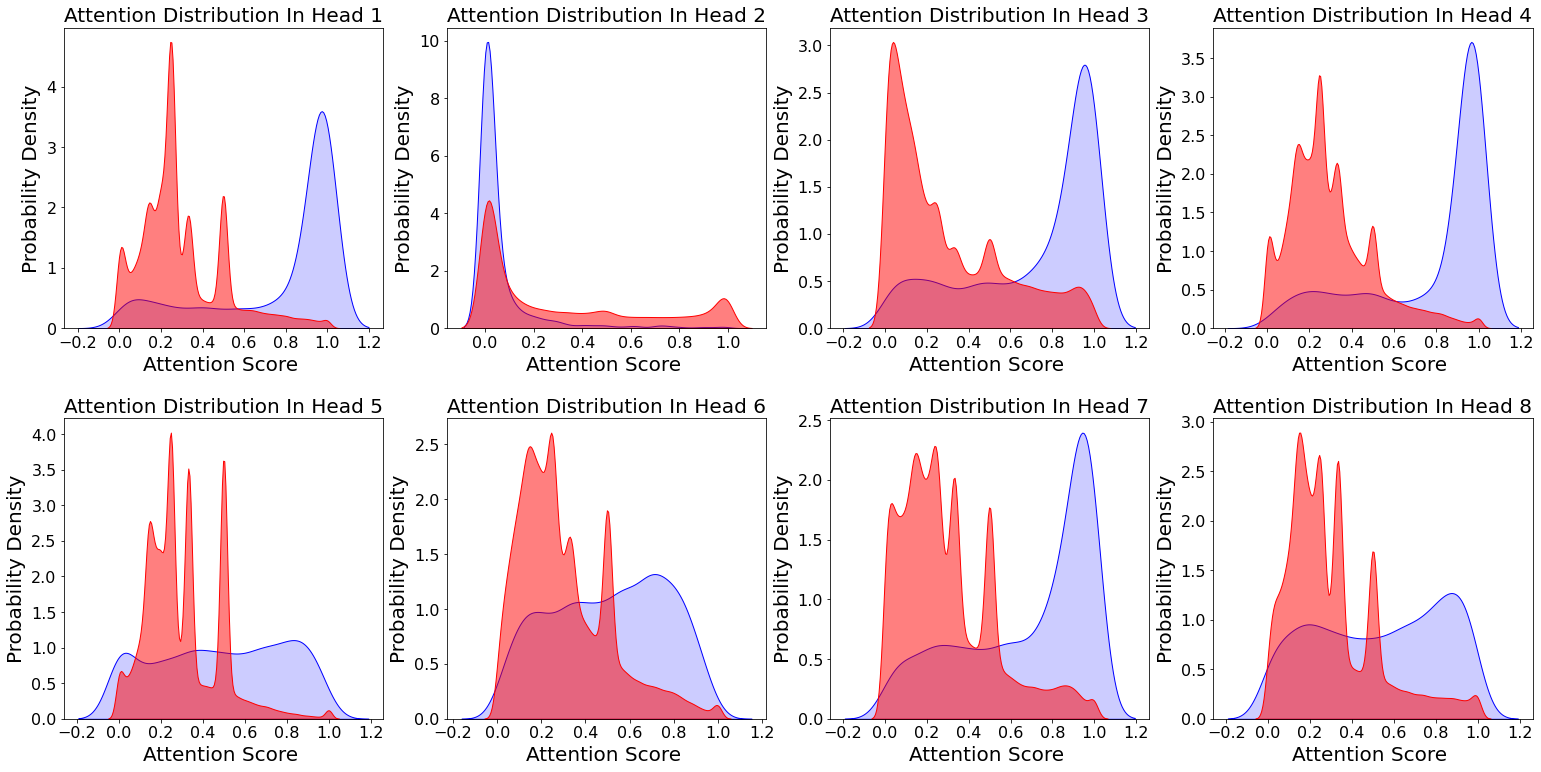

In [55]:

import matplotlib.pyplot as plt
all_attnFP = np.concatenate(all_attnFP,axis = 0)
all_attnCovalent = np.concatenate(all_attnCovalent,axis = 0)
plt.figure(figsize = (24,12))
plt.subplots_adjust(left=0.1,bottom=0.1,top=0.9,right=0.95,hspace=0.3,wspace=0.2)

for idx in range(8):
    import seaborn as sns

    ax = plt.subplot(2,4,idx+1)

    data = pd.DataFrame({'score attns':all_attnFP[:,idx].flatten()})
    sns.kdeplot(data['score attns'], fill=True, color='b',label="IFP Edge",alpha = 0.2)
    data_res= pd.DataFrame({'score attns':all_attnCovalent[:,idx].flatten()})
    sns.kdeplot(data_res['score attns'], fill=True, color='r',label="Covalent Edge",alpha = 0.5)
    ax.set_ylabel( "Probability Density", fontsize=20, labelpad=5 )
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlabel( "Attention Score ",fontsize=20 ,labelpad=5)
    ax.set_title(  "Attention Distribution In Head {}".format(idx + 1),loc='center', fontsize=20)
# plt.title(  "attention score distribution in different edge",loc='center', fontsize=20  )
plt.show()